In [2]:
# !pip install --upgrade numba
!pip install -qq sktime numba

# ROCKET 特徴量を用いた分類

- [参考としたノートブック](https://github.com/sktime/sktime/blob/main/examples/rocket.ipynb)
- [データセット説明リンク](https://www.timeseriesclassification.com/description.php?Dataset=BasicMotions)
- The data order is accelerometer x, y, z then gyroscope x, y, z. There are classes: walking, resting, running and badminton.

In [3]:
from matplotlib import pyplot as plt
plt.rcParams["font.size"] = 18

In [4]:
from sktime.datasets import load_basic_motions
X_train, y_train = load_basic_motions(split="train", return_X_y=True)

In [5]:
X_train.head()

dim_0  \
0  0     0.079106
1     0.079106
2    -0.903497
3...   
1  0     0.377751
1     0.377751
2     2.952965
3...   
2  0    -0.813905
1    -0.813905
2    -0.424628
3...   
3  0     0.289855
1     0.289855
2    -0.669185
3...   
4  0    -0.123238
1    -0.123238
2    -0.249547
3...   

                                               dim_1  \
0  0     0.394032
1     0.394032
2    -3.666397
3...   
1  0    -0.610850
1    -0.610850
2     0.970717
3...   
2  0     0.825666
1     0.825666
2    -1.305033
3...   
3  0     0.284130
1     0.284130
2    -0.210466
3...   
4  0     0.379341
1     0.379341
2     0.541501
3...   

                                               dim_2  \
0  0     0.551444
1     0.551444
2    -0.282844
3...   
1  0    -0.147376
1    -0.147376
2    -5.962515
3...   
2  0     0.032712
1     0.032712
2     0.826170
3...   
3  0     0.213680
1     0.213680
2     0.252267
3...   
4  0    -0.286006
1    -0.286006
2     0.208420
3...   

                                               dim_3  \
0  0     0.351565
1     0.351565
2    -0.095881
3...   
1  0    -0.103872
1    -0.103872
2    -7.593275
3...   
2  0     0.021307
1     0.021307
2    -0.372872
3...   
3  0    -0.314278
1    -0.314278
2     0.018644
3...   
4  0    -0.098545
1    -0.098545
2    -0.023970
3...   

                                               dim_4  \
0  0     0.023970
1     0.023970
2    -0.319605
3...   
1  0    -0.109198
1    -0.109198
2    -0.697804
3...   
2  0     0.122515
1     0.122515
2    -0.045277
3...   
3  0     0.074574
1     0.074574
2     0.007990
3...   
4  0     0.058594
1     0.058594
2     0.175783
3...   

                                               dim_5  
0  0     0.633883
1     0.633883
2     0.972131
3...  
1  0    -0.037287
1    -0.037287
2    -2.865789
3...  
2  0     0.775041
1     0.775041
2     0.383526
3...  
3  0    -0.079901
1    -0.079901
2     0.237040
3...  
4  0    -0.074574
1    -0.074574
2     0.114525
3...

In [6]:
X_train.loc[0]['dim_0']

0     0.079106
1     0.079106
2    -0.903497
3     1.116125
4     1.638200
        ...   
95   -0.167918
96   -0.227670
97   -0.193271
98   -0.193271
99   -0.205150
Length: 100, dtype: float64

In [7]:
y_train

array(['standing', 'standing', 'standing', 'standing', 'standing',
       'standing', 'standing', 'standing', 'standing', 'standing',
       'running', 'running', 'running', 'running', 'running', 'running',
       'running', 'running', 'running', 'running', 'walking', 'walking',
       'walking', 'walking', 'walking', 'walking', 'walking', 'walking',
       'walking', 'walking', 'badminton', 'badminton', 'badminton',
       'badminton', 'badminton', 'badminton', 'badminton', 'badminton',
       'badminton', 'badminton'], dtype='<U9')

In [8]:
import pandas as pd
acceleration_timeseries = (X_train['dim_0']**2 + X_train['dim_1']**2 + X_train['dim_2']**2)**(1/2)
angular_velocity_timeseries = (X_train['dim_3']**2 + X_train['dim_4']**2 + X_train['dim_5']**2)**(1/2)

## 原点からの距離

- 赤： standing
- 青： running
- 緑： wakling
- 橙： orange

Text(0, 0.5, 'Distance')

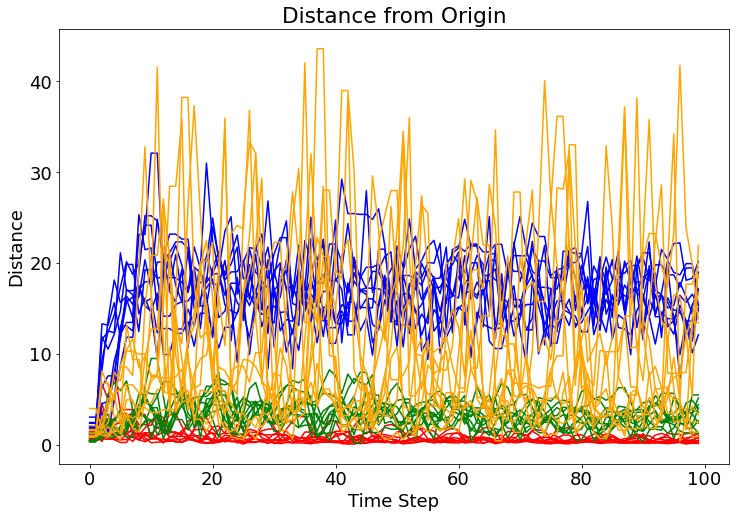

In [9]:
for data, label in zip(acceleration_timeseries, y_train):
    if label == 'standing':
        c = 'r'
    elif label == 'running':
        c = 'b'
    elif label == 'walking':
        c = 'g'
    else:
        c = 'orange'
    data.plot(figsize=(12, 8), c=c)
plt.title("Distance from Origin")
plt.xlabel("Time Step")
plt.ylabel("Distance")

## 角速度

- 赤： standing
- 青： running
- 緑： wakling
- 橙： orange

Text(0, 0.5, 'Angular Velocity')

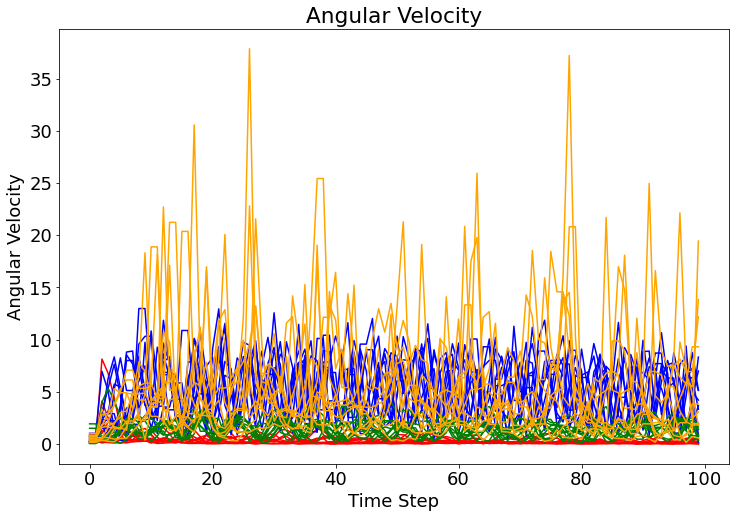

In [10]:
for data, label in zip(angular_velocity_timeseries, y_train):
    if label == 'standing':
        c = 'r'
    elif label == 'running':
        c = 'b'
    elif label == 'walking':
        c = 'g'
    else:
        c = 'orange'
    data.plot(figsize=(12, 8), c=c)
plt.title("Angular Velocity")
plt.xlabel("Time Step")
plt.ylabel("Angular Velocity")

# Initialise ROCKET and Transform the Training Data

In [11]:
from sktime.transformations.panel.rocket import Rocket
rocket = Rocket()
rocket.fit(X_train)

/opt/conda/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12040. The TBB threading layer is disabled.
  warnings.warn(problem)


In [25]:
keys = ['weights', 'lengths', 'biases', 'dilations', 'paddings', 'num_channel_indices', 'channel_indices']
for key, value in zip(keys, rocket.kernels):
    print(f"key: {key.ljust(20)} | shape: {str(value.shape).ljust(10)} | head: {value[:5]}")

key: weights              | shape: (235595,)  | head: [ 0.46962827 -0.3619526   1.5579517  -1.2854773   1.4086924 ]
key: lengths              | shape: (10000,)   | head: [ 7 11  9  7 11]
key: biases               | shape: (10000,)   | head: [ 0.38705754 -0.89311105 -0.5834846  -0.28147268 -0.71177727]
key: dilations            | shape: (10000,)   | head: [2 2 2 1 7]
key: paddings             | shape: (10000,)   | head: [6 0 8 3 0]
key: num_channel_indices  | shape: (10000,)   | head: [4 1 3 3 6]
key: channel_indices      | shape: (26209,)   | head: [2 0 3 4 2]


各変数の細かい説明は [こちら](https://qiita.com/takahashi-ry/items/8563ebcca1363fadf106)

In [29]:
(weights, lengths, biases, dilations, paddings, num_channel_indices, channel_indices) = rocket.kernels

`num_channel_indices` で各 kernel を作る際に採用する列数情報がある。列数が 4 のときはオリジナルのテーブルから 4 列をランダムに選ぶ。  
`channel_indices` に選び出された列番号を順番に格納していっているため、`channel_indcies=num_channel_indices`

In [32]:
print(f"{len(channel_indices)} = {sum(num_channel_indices)}")

26209 = 26209


`num_channel_indices * lengths` だけ `weights` を用意する。

In [41]:
print(f"{len(weights)} = {sum(lengths*num_channel_indices)}")

235595 = 235595


In [12]:
X_train_transform = rocket.transform(X_train)
print(X_train_transform.shape)
X_train_transform.head()

(40, 20000)


0          1       2         3      4          5      6          7      \
0   0.64  16.611792  0.2125  3.158106   0.39  14.256186   0.42  16.349295   
1   0.71  23.913975  0.0625  5.928816   0.43  13.716615   0.37  16.242657   
2   0.55  10.828066  0.2875  3.270846   0.49   9.006702   0.43   9.874355   
3   0.54  10.957155  0.3250  2.742664   0.43  10.746840   0.52  10.925000   
4   0.50  13.571008  0.2875  1.547936   0.47  10.797802   0.49  12.944530   

      8          9      ...     19990      19991  19992      19993     19994  \
0  0.433333   8.195324  ...  0.655556   8.617981   0.50  24.295311  0.659574   
1  0.433333  13.022827  ...  0.677778  35.929161   0.53  16.757946  0.840426   
2  0.400000  14.059261  ...  0.544444  13.393063   0.52  16.717676  0.606383   
3  0.333333  15.287141  ...  0.600000  16.870882   0.48  18.519081  0.542553   
4  0.500000  10.244529  ...  0.500000  11.732138   0.47  16.161341  0.585106   

      19995     19996      19997     19998      19999  
0  9.404009  0.488889  18.046894  0.596154  10.212542  
1  3.812294  0.377778  18.686184  0.596154   3.025173  
2  8.746964  0.500000   8.430334  0.557692   9.939734  
3  9.587808  0.511111  12.674031  0.576923   8.686691  
4  8.950008  0.455556  16.492121  0.538462  10.458825  

[5 rows x 20000 columns]

## Fit a Classifier

In [13]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_train_transform, y_train)

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))

## Load and Transform the Test Data

In [14]:
X_test, y_test = load_basic_motions(split="test", return_X_y=True)
X_test_transform = rocket.transform(X_test)

## Classify the Test Data

In [15]:
print(f"Train score: {classifier.score(X_train_transform, y_train)}")
print(f"Test score: {classifier.score(X_test_transform, y_test)}")

Train score: 1.0
Test score: 0.975
